# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 : 

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg
!wget --content-disposition https://unsplash.com/photos/tlMNfElG87U/download?force=true -O reflex_cam.jpg
!wget --content-disposition https://unsplash.com/photos/wu9Xr4rt5cU/download?force=true -O table.jpg
!wget --content-disposition https://unsplash.com/photos/gtoD_k0dSqM/download?force=true -O bone.jpg


--2020-12-27 14:53:10--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl [following]
--2020-12-27 14:53:10--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.001s  

2020-12-27 14:53:11 (25.4 MB/s) - 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



golf ball  :  0.27057576
piggy bank, penny bank  :  0.2037392
conch  :  0.12198341


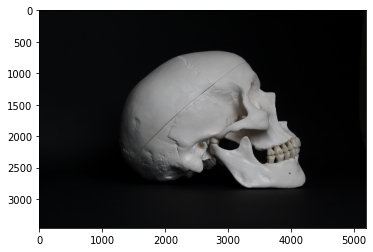

In [ ]:
cat = Image.open('cat.jpg')
#dog = Image.open('dog.jpg')
#plt.imshow(cat)
#plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("bone.jpg")
plt.imshow(img)
img = img.resize((224, 224), Image.BILINEAR)
img = (np.array(img, dtype=np.float32) / 255 - np.array([0.485,0.456,0.406]))/np.array([0.229,0.224,0.225])
img = img.transpose((2, 0, 1))

img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x)

softmax_func = nn.Softmax(dim=1)
y = softmax_func(y)
#y = y.detach().cpu().numpy() # transformation en array numpy
y = y.detach().cpu()

#Top 3 classif 
proba, y_hat = torch.topk(y, 3, dim=1)
proba = proba.numpy()
y_hat = y_hat.numpy()

#y_hat = np.argmax(y)
for i, p in enumerate(proba[0]):
  print(imagenet_classes[y_hat[0][i]], " : ", p)

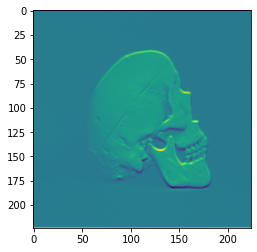

In [ ]:
y = vgg16(x)
#Application premiere couche de convolution avec features[0]
I = vgg16.features[0](x)
#plt.imshow(I[0,0].detach().cpu().numpy())

plt.imshow(I[0,5].detach().cpu().numpy())

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!unzip 15ScenesData.zip

--2020-12-27 14:53:27--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip [following]
--2020-12-27 14:53:27--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   189MB/s    in 0.4s    

2020-12-27 14:53:28 (189 MB/s) - ‘15Scenes

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # recopier toute la partie convolutionnelle
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # garder une partie du classifieur, -2 pour s'arrêter à relu7
    #self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:2])
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])

        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(duplicateChannel),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = np.empty((0,4096))
    y = np.empty((0))
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        output = model(Variable(input))
        x_feat = output.data.cpu().numpy()
        x_feat = x_feat / np.linalg.norm(x_feat, 2, 1, True)
        X = np.append(X, x_feat, axis=0)
        y = np.append(y, target.numpy())
        ####################
        ##      FIN        #
        ####################    

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    #Dimension d'entrée à la premiére couche du classifieur
    #print(vgg16.classifier[0].in_features)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    ####################
    ##      FIN        #
    ####################      
    
    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)


    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1)
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################    
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.906868


In [ ]:
class GradientDescent(object):

    def __init__(self, model, eps, epoch):
        self.model = model
        self.eps = eps
        self.epoch = epoch
        

    def descente_gradient(self, loader_train, loader_test):

        #parametre à optimiser
        optim = torch.optim.Adam(self.model.parameters(), lr=self.eps)

        criterion = nn.CrossEntropyLoss()

        MAX_ACCURACY=0
        SAVE_EPOCH=0
        for n_iter in range(self.epoch):
            cumul_loss = 0
            count_batch = 0
            accuracy=0
            for batch in loader_train:
                self.model.train()
                #Reinitialisation du gradient
                optim.zero_grad()

                output = self.model(batch[0].cuda())
                target = batch[1].long().cuda()
                
                loss = criterion(output, target)
                loss.backward()
                
                #Mise à jour paramétres du modéle
                optim.step()


                cumul_loss +=loss / len(batch[0])
                #Accuracy
                soft_m = torch.tensor(nn.functional.softmax(output, dim=1))
                label = torch.argmax(soft_m, dim=1)
                accuracy += (label==target.long()).sum().item() / len(target)
                
                count_batch +=1


            # Sortie directe
            print(f"Itérations {n_iter}: loss/train {cumul_loss}")
            print(f"Itérations {n_iter}: ACCU/train {accuracy/count_batch}")

            #Evalute loss in test
            with torch.no_grad():
                self.model.eval()
                cumul_loss = 0
                accuracy=0
                count_batch=0
                for batch in loader_test:

                    output = self.model(batch[0].cuda())
                    target = batch[1].long().cuda()

                    loss = criterion(output, target)
                    
                    cumul_loss +=loss / len(batch[0])

                    #Accuracy
                    soft_m = torch.tensor(nn.functional.softmax(output, dim=1))
                    label = torch.argmax(soft_m, dim=1)
                    accuracy += (label==target.long()).sum().item() / len(target)
                
                    count_batch +=1

            
            # Sortie directe
            print(f"Itérations {n_iter}: loss/test {cumul_loss}")
            print(f"Itérations {n_iter}: ACCU/test {accuracy/count_batch}")

            if MAX_ACCURACY < accuracy/count_batch :
              MAX_ACCURACY = accuracy/count_batch
              SAVE_EPOCH = n_iter
        
        return MAX_ACCURACY, SAVE_EPOCH

In [ ]:
def main2(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    #Freeze le Reseau pour ne pas backpropagé
    for param in vgg16.parameters():
      param.requires_grad = False

    #Remplacement dernière couche pas notre propre couche
    features_in = vgg16.classifier[-1].in_features
    vgg16.classifier[-1] = nn.Linear(features_in, 15)     
    
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        vgg16 = vgg16.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage')
    LR = 0.0001
    EPOCH = 100 
    optimizer = GradientDescent(vgg16, LR, EPOCH)
    accuracy, epoch = optimizer.descente_gradient(train, test)

    print('Accuracy = %f' % accuracy)
    print('Epoch = %f' % epoch)

In [ ]:
main2("15SceneData", 8)

Instanciation de VGG16
Récupération des données
Apprentissage


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Itérations 0: loss/train 81.59764862060547
Itérations 0: ACCU/train 0.03324468085106383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Itérations 0: loss/test 87.37227630615234
Itérations 0: ACCU/test 0.6280080213903744
Itérations 1: loss/train 42.63790512084961
Itérations 1: ACCU/train 0.36569148936170215
Itérations 1: loss/test 56.542381286621094
Itérations 1: ACCU/test 0.6684491978609626
Itérations 2: loss/train 30.244190216064453
Itérations 2: ACCU/train 0.5611702127659575
Itérations 2: loss/test 42.14234161376953
Itérations 2: ACCU/test 0.7276069518716578
Itérations 3: loss/train 23.60992431640625
Itérations 3: ACCU/train 0.6708776595744681
Itérations 3: loss/test 34.42599868774414
Itérations 3: ACCU/test 0.7824197860962567
Itérations 4: loss/train 19.27490997314453
Itérations 4: ACCU/train 0.75
Itérations 4: loss/test 29.548519134521484
Itérations 4: ACCU/test 0.8135026737967914
Itérations 5: loss/train 16.527570724487305
Itérations 5: ACCU/train 0.7719414893617021
Itérations 5: loss/test 26.719144821166992
Itérations 5: ACCU/test 0.8292112299465241
Itérations 6: loss/train 14.484148025512695
Itérations 6: ACCU/